# Missing Contacts
You might find that some contacts that you were **expecting** to be found by ``mdciao`` don't actually show up in ``mdciao``'s results. Several input parameters control the contact reporting of ``mdciao``, and it might not be obvious which one of them (if any) is actually *hiding* your contact. The logic behind these parameters, and their default values, is fairly straightforward, and we illustrate it here.

## ctc_cutoff_Ang
This is the most obvious parameter that controls the contact computation. It appears virtually in all methods (CLI or API) that compute contact frequencies. Whenever it has a default value, it is **3.5 Angstrom**.

<div class="alert alert-info">
    
<b>Note</b> 
    
Please see the *note of caution* on the use of hard cutoffs in the [main page of the docs](https://proteinformatics.uni-leipzig.de/mdciao/index.html).

</div>

In [1]:
import mdciao, mdtraj as md
traj = md.load("mdciao_example/traj.xtc",top="mdciao_example/prot.pdb")

First, we individually call [mdciao.cli.residue_neighborhoods](file:///home/guille/Programs/mdciao/doc/_build/html/api/generated/generated/mdciao.cli.residue_neighborhoods.html) with two ``ctc_cutoff_Ang`` values, 3.0 and 3.5 Angstrom. This will generate two frequency reports which we will later compare with [mdciao.cli.compare](file:///home/guille/Programs/mdciao/doc/_build/html/api/generated/generated/mdciao.cli.compare.html). Please refer to those methods if their function calls aren't entirely clear to you.


These interactions are not shared:
L230, R385
Their cumulative ctc freq is 0.33. 
Created files
freq_comparison.pdf
freq_comparison.xlsx


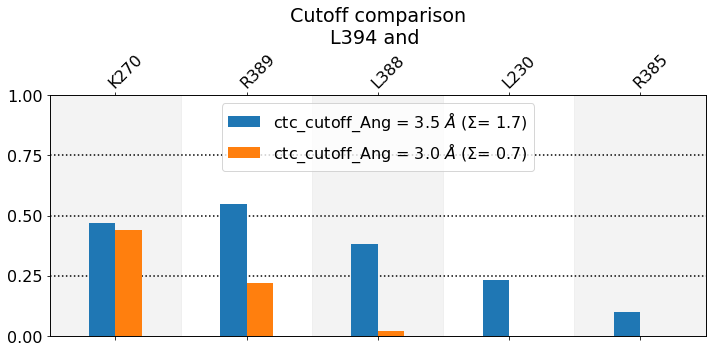

In [2]:
from io import StringIO
from contextlib import redirect_stdout
b = StringIO()
with redirect_stdout(b):
    for ctc_cutoff_Ang in [3, 3.5]:
        mdciao.cli.residue_neighborhoods("L394",traj, 
                                         short_AA_names=True,
                                         ctc_cutoff_Ang=ctc_cutoff_Ang,
                                         figures=False, 
                                         fragment_names=None,
                                         no_disk=False)
mdciao.cli.compare({
    "ctc_cutoff_Ang = 3.5 AA" : "neighborhood.LEU394@3.5_Ang.dat", 
    "ctc_cutoff_Ang = 3.0 AA" : "neighborhood.LEU394@3.0_Ang.dat",
                   },
                   anchor="L394",
                  title="Cutoff comparison");
b.close()

<div class="alert alert-info">
    
<b>Note</b> 
    
We are hiding most outputs with the use of [redirect_stdout](https://docs.python.org/3/library/contextlib.html).

</div>

We observe that the smaller the cutoff, the fewer contacts get reported. In this case ``L230`` and ``R385`` never approach ``L394`` at distances smaller than 3.0 Angstrom during in the entire simulation, hence they don't get reported.  As for ``K270``, the frequency doesn't change very much, because it's a salt-bridge that's really either formed at very close distance or broken at higher distances, as can be seen in this [time-trace figure](https://proteinformatics.uni-leipzig.de/mdciao/_images/banner.png). Also notice that, at 3.5 Angstrom, the sum over bars, $\Sigma$, is higher, since the height of the bars has increased.

## ctc_control
Even when using the same ``ctc_cutoff_Ang``, there's other ways of controlling what gets reported. ``ctc_control`` is one of them. This parameter controls **how many** residues get reported per neighborhood, since usually one is not interested in **all** residues but only the most frequent ones. 

### Controlling with integers
One way to control this is to select only the first *n* frequent ones (*n* is an integer and is **5** by default). Here we do the comparison again:

These interactions are not shared:
I233, L230, R385
Their cumulative ctc freq is 0.93. 
Created files
freq_comparison.pdf
freq_comparison.xlsx


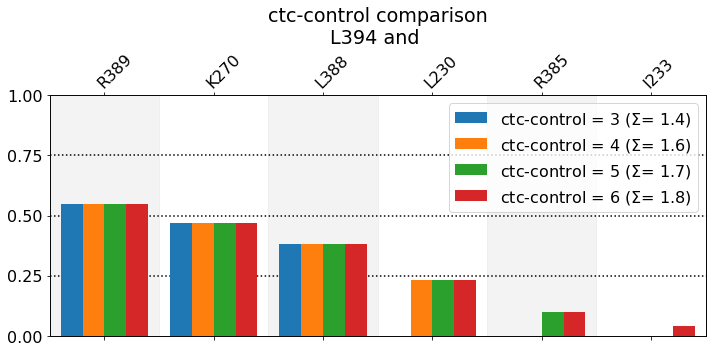

In [3]:
b = StringIO()
ctc_cutoff_Ang = 3.5
ctc_controls = [3,4,5,6]
with redirect_stdout(b):
    for ctc_control in ctc_controls:
        mdciao.cli.residue_neighborhoods("L394",traj, 
                                         short_AA_names=True,
                                         ctc_cutoff_Ang=ctc_cutoff_Ang,
                                         ctc_control=ctc_control,
                                         figures=False, 
                                         fragment_names=None,
                                         no_disk=False,
                                         output_desc='neighborhood.ctc_control_%u'%ctc_control)
mdciao.cli.compare({"ctc-control = %u"%key : "neighborhood.ctc_control_%u.LEU394@%2.1f_Ang.dat"%(key,ctc_cutoff_Ang)
                   for key in ctc_controls},
                   anchor="L394",
                  title="ctc-control comparison");
b.close()

*n* is simply the number of reported bars: three blue ones, four orange ones, five green ones, and six red ones. $\Sigma$ is just the sum of the heights of all bars and is thus an estimate of the **average number of neighbors** that are being reported (at this cutoff). A couple of observations:


* The relation of $\Sigma$ with *n* is straightforward: as *n* grows, so does $\Sigma$.


* For a fixed cutoff, there's an upper bond to $\Sigma$ ($\Sigma\leq\Sigma_t$), because the **total average number of neighbors**, $\Sigma_t$, of a given residue, over a given dataset, is determined by the used cutoff only. The ``ctc_control`` parameter simply determines how many neighbors get actually reported.


* Because neighbors get reported by descending frequency, the neighbors that get left out when chosen *n* = 4 over *n* = of 5 or 6 are very likely not that significant. Please note that this won't hold for very small datasets (like one single pdb file), where the word *frequency* doesn't really have a defined meaning.


* In cases where ``mdciao`` is used to look for the neighborhood of just one residue, there's a sensible number of residues to choose (somewhere between 5 and 10), because *usually* that's how many interactions a residue will have (please note, this doesn't necessary hold for elongated ligands, lipids, acid chains etc).

Actually, although it's hidden above, ``mdciao`` reports to the terminal the percentage of $\Sigma_t$ that the report captures, so that the user can decided whether to increase *n* or not, so for each of the iterations above, here are terminal-output excerpts:

* ``ctc_control = 3``
 ```
 #idx   freq      contact       fragments     res_idxs      ctc_idx  Sum
 1:     0.55   LEU394-ARG389       0-0         353-348        30     0.55
 2:     0.47   LEU394-LYS270       0-3         353-972        65     1.02
 3:     0.38   LEU394-LEU388       0-0         353-347        29     1.39
 These 3 contacts capture 1.39 (~79%) of the total frequency 1.76 (over 74 input contacts)
 As orientation value, the first 4 ctcs already capture 90.0% of 1.76.
 The 4-th contact has a frequency of 0.23
 ```
 The intention is to report how much of $\Sigma_t$ has been captured using 3 contacts (~79%), and how many would be needed to capture most (90%) of it (4 contacts). So, as we increase *n*:
 
* ``ctc_control = 4``
 ```
 #idx   freq      contact       fragments     res_idxs      ctc_idx  Sum
 1:     0.55   LEU394-ARG389       0-0         353-348        30     0.55
 2:     0.47   LEU394-LYS270       0-3         353-972        65     1.02
 3:     0.38   LEU394-LEU388       0-0         353-347        29     1.39
 4:     0.23   LEU394-LEU230       0-3         353-957        51     1.62
 These 4 contacts capture 1.62 (~92%) of the total frequency 1.76 (over 74 input contacts)
 ```
 
* ``ctc_control = 5``
 ```
 #idx   freq      contact       fragments     res_idxs      ctc_idx  Sum
 1:     0.55   LEU394-ARG389       0-0         353-348        30     0.55
 2:     0.47   LEU394-LYS270       0-3         353-972        65     1.02
 3:     0.38   LEU394-LEU388       0-0         353-347        29     1.39
 4:     0.23   LEU394-LEU230       0-3         353-957        51     1.62
 5:     0.10   LEU394-ARG385       0-0         353-344        26     1.73
 These 5 contacts capture 1.73 (~98%) of the total frequency 1.76 (over 74 input contacts)
 ```
 
* ``ctc_control = 6``
 ```
 #idx   freq      contact       fragments     res_idxs      ctc_idx  Sum
 1:     0.55   LEU394-ARG389       0-0         353-348        30     0.55
 2:     0.47   LEU394-LYS270       0-3         353-972        65     1.02
 3:     0.38   LEU394-LEU388       0-0         353-347        29     1.39
 4:     0.23   LEU394-LEU230       0-3         353-957        51     1.62
 5:     0.10   LEU394-ARG385       0-0         353-344        26     1.73
 6:     0.04   LEU394-ILE233       0-3         353-960        54     1.76
 These 6 contacts capture 1.76 (~100%) of the total frequency 1.76 (over 74 input contacts)
 ```

### Controlling with fractions
Additionally, the **upper bond** itself,  $\Sigma_t$, can be used as a reference for controlling how many contacts get reported. So, instead of specifying an absolute number (*n* = 3,4,5...), one can specify a relative number, i.e. a fraction of $\Sigma_t$ to be reported. 

This way, regardless of the actual number of involved contacts, one can choose to report **most of them**. In the example below, we choose to report 90% of the total number of average neighbors, which, as we know from above, is achieved with 4 contacts. To avoid introducing a new parameter, ``mdciao`` knows that if ``ctc_control`` is an integer (1, 2, 3...), the user means *this many contacts*, whereas if ``ctc_control`` is between 0 and 1 (.50 for 50%, .9 for 90% etc) the user wants that fraction of $\Sigma_t$:

In [4]:
mdciao.cli.residue_neighborhoods("L394",traj, 
                                 short_AA_names=True,
                                 ctc_cutoff_Ang=ctc_cutoff_Ang,
                                 ctc_control=.90,
                                 figures=False, 
                                 fragment_names=None,
                                 no_disk=False,
                                 );

Will compute contact frequencies for (1 items):
<mdtraj.Trajectory with 280 frames, 8384 atoms, 1044 residues, and unitcells>
 with a stride of 1 frames
Using method 'lig_resSeq+' these fragments were found
fragment      0 with  354 AAs     LEU4           (   0) -   LEU394           (353 ) (0)  resSeq jumps
fragment      1 with  340 AAs     GLN1           ( 354) -   ASN340           (693 ) (1) 
fragment      2 with   66 AAs     ALA2           ( 694) -    PHE67           (759 ) (2) 
fragment      3 with  283 AAs    GLU30           ( 760) -   LEU340           (1042) (3)  resSeq jumps
fragment      4 with    1 AAs   P0G395           (1043) -   P0G395           (1043) (4) 

Will compute neighborhoods for the residues
L394
excluding 4 nearest neighbors

   residue      residx    fragment      resSeq         BW        CGN
    LEU394         353           0        394       None       None

Pre-computing likely neighborhoods by reducing the neighbor-list
to those within 15 Angstrom in the fir

Which control-mode to choose (fraction or integers) is up to the user:

* For **compactness**, limiting the output with integers can avoid huge outputs, but might leave out some interesting stuff.

* For **completeness**, choosing ``ctc_control = .99`` will ensure that any-residue under the cutoff (regardless of its frequency) will be reported, but might fill the reports with "long tails" of many residues with very low frequencies.

## n_nearest

Another way in which ``mdciao`` is choosing which residues to show is through excluding **nearest neighbors**, i.e. residues that are predictably going to be under the cutoff simply because they are bonded neighbors of the residue in question.

In our example, for ``L394`` these would be residues 395 and 393 (first bonded) 396 and 392 (second bonded) and so on (except, in this particular ``L394`` case, since it's a terminal residue, we only get 393, 392 etc). By the way, the meaning of *bonded* can be clarified 

The default value that ``mdciao`` has this parameter is ``n_nearest=4`` by default, which is approximately one $\alpha$-helix turn away. The intention is to avoid reporting up to the first helix away from the residue.

Let's see the effect of varying this parameter:


These interactions are not shared:
E392, L393
Their cumulative ctc freq is 3.00. 
Created files
freq_comparison.pdf
freq_comparison.xlsx


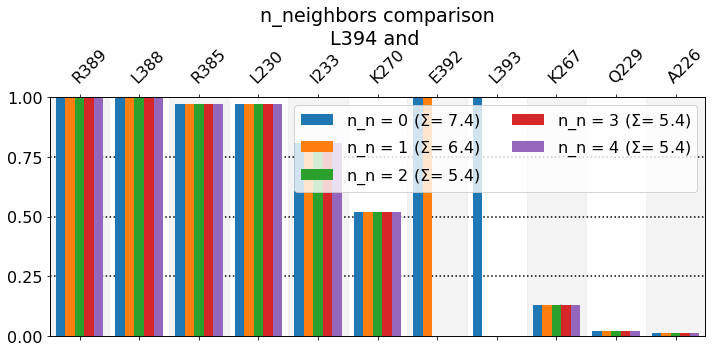

In [5]:
b = StringIO()
ctc_cutoff_Ang = 4.5
n_nearests = [0, 1, 2, 3, 4]
with redirect_stdout(b):
    for n_nearest in n_nearests:
        n = mdciao.cli.residue_neighborhoods("L394",traj, 
                                         short_AA_names=True,
                                         ctc_cutoff_Ang=ctc_cutoff_Ang,
                                         ctc_control=20,
                                         n_nearest=n_nearest,
                                         figures=False, 
                                         fragment_names=None,
                                         no_disk=False,
                                         output_desc='neighborhood.n_nearest_%u'%n_nearest)
mdciao.cli.compare({"n_n = %u"%key : "neighborhood.n_nearest_%u.LEU394@%2.1f_Ang.dat"%(key,ctc_cutoff_Ang)
                   for key in n_nearests},
                   anchor="L394",
                   title="n_neighbors comparison");
b.close()


We can see also here that, the lower ``n_neighbors``, i.e. the less neighbors we exclude, the higher the $\Sigma$ value. With ``n_neighbors=0``, in the report we see ``E392`` and ``L393``, both with full bars. Since ``L393`` is covalently bonded to ``L394``, thi sis expected (and hence not particularly informative). While ``L392`` is not bonded to ``L394``, there's a strong expectation for it to be near ``L394``, so this is also not very informative. So, as ``n_neighbors`` goes up, these two bars get hidden, and the graph doesn't change anymore. If you're wondering what's with position 391, there's a TYR that points away from ``L394`` throughout the simulation, so it wouldn't appear on the report regardless.

## nlist_cutoff_Ang

In order to speed up computations, ``mdciao`` creates an initial neighborlist from the topology file, or the first frame of the trajectory when no topology is passed. Only residues that are within ``nlist_cutoff_Ang`` in that frame are considered potential neighbors, s.t. non-necessary distances between distant domains aren't unnecessarily computed, like the N-term of a receptor and Gamma sub-unit of a G-protein. This is admittedly risky in some cases, and will likely change in future versions of ``mdciao`` (perhaps using kdtrees), but in general it works well if no large conformational changes take place during the simulation. 

Conveniently, ``mdciao`` informs about this in the output by saying (e.g. in the terminal output from above):
```
Pre-computing likely neighborhoods by reducing the neighbor-list
to those within 15 Angstrom in the first frame of reference geom
'<mdtraj.Trajectory with 1 frames, 8384 atoms, 1044 residues, and unitcells>':...done!
From 1035 potential distances, the neighborhoods have been reduced to only 74 potential contacts.
If this number is still too high (i.e. the computation is too slow), consider using a smaller nlist_cutoff_Ang 
```

Some known cases where the assumption that initial neighborhood (up to ``nlist_cutoff_Ang`` Angstrom) already contains all potential neighbors doesn't hold: 

* **binding simulations**: 
  If in your first frame the binding partners are far apart, but get closer during your simulation, the actual neighbors will be missing in the initial neighborlist. Binding partners can be anything: ligand and substrate, protein A and protein B, sub-unit $\alpha$ and $\beta$, whatever you want. In these cases, you can either use the final frame of the simulation as a reference frame, or simply increase the ``nlist_cutoff_Ang`` to a value that captures all possible contacts, although this might slow down the computation.

* **docking data**:
  Docking data might contain many different poses where the ligand is sampling not only the orthosteric binding pocket, but anything else found by the algorithm. Since there's no single one representative frame for all this poses, you have to increase ``nlist_cutoff_Ang`` for this.

* **randomized-data**: 
  In general, any type of data where there's a **strong expectation** of large conformational variability, beyond local rearrangements contained in the ``nlist_cutoff_Ang``, should be handled carefully.

  

## interface_cutoff_Ang
When computing whole interfaces, rather than just residue neighborhoods, ``nlist_cutoff_Ang`` is called ``interface_cutoff_Ang``, but it's the same concept. Since the user is no longer looking at individual residue neighborhoods, but rather entire interfaces between molecular fragments, i.e. (sub) domains consisting of many residues, we assume that larger conformational changes are expected and thus set the default value at 35 Angstrom.

## Finally
Some of these parameters/criteria appear in other places in ``mdciao``, not only at the moment of computing the distances, but also at the moment of showing them. E.g., the method [mdciao.cli.flare.freqs2flare](https://proteinformatics.uni-leipzig.de/mdciao/api/generated/mdciao.flare.freqs2flare.html) automatically hides neighboring contacts via the ``exclude_neighbors = 1`` parameter.

So, if at any moment you miss some contact in the reports (graphical or otherwise), check if some of the parameters above are at play.